<a href="https://colab.research.google.com/github/BibitAji/ProjectCV/blob/main/Finetune_Freeze_Oxford_Flower.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fine Tuning and Freeze model**

In [ ]:
# Imports here
import json
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
print(models.resnet34())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bibitwaluyoaji","key":"7eebdfa18346e78d7cc699f396cdff20"}'}

In [ ]:

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c oxford-102-flower-pytorch

 95% 314M/330M [00:02<00:00, 136MB/s]
100% 330M/330M [00:02<00:00, 140MB/s]


In [ ]:
!unzip oxford-102-flower-pytorch.zip

Archive:  oxford-102-flower-pytorch.zip
  inflating: flower_data.zip         
  inflating: sample_submission.csv   


In [ ]:
!unzip flower_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: flower_data/train/50/image_06553.jpg  
  inflating: flower_data/train/50/image_06554.jpg  
  inflating: flower_data/train/50/image_06555.jpg  
  inflating: flower_data/train/50/image_06556.jpg  
  inflating: flower_data/train/50/image_06557.jpg  
  inflating: flower_data/train/50/image_06559.jpg  
  inflating: flower_data/train/50/image_06560.jpg  
  inflating: flower_data/train/50/image_06561.jpg  
  inflating: flower_data/train/50/image_06563.jpg  
  inflating: flower_data/train/50/image_06564.jpg  
  inflating: flower_data/train/50/image_06565.jpg  
  inflating: flower_data/train/50/image_06566.jpg  
  inflating: flower_data/train/50/image_06567.jpg  
  inflating: flower_data/train/50/image_06568.jpg  
  inflating: flower_data/train/50/image_06569.jpg  
  inflating: flower_data/train/50/image_06570.jpg  
   creating: flower_data/train/51/
  inflating: flower_data/train/51/image_01317.jpg  
  inflating: flower_data/train

In [ ]:
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
name_json = data_dir + '/cat_to_name.json'

In [ ]:
data_dir

'flower_data'

## data

In [ ]:

# TODO: Define your transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
# TODO: Load the datasets with ImageFolder
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/valid', transform=valid_transforms)


# TODO: Using the image datasets and the trainforms, define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)


In [ ]:
def pil_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

In [ ]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.files = []
        for (dirpath, _, filenames) in os.walk(self.path):
            for f in filenames:
                if f.endswith('.jpg'):
                    p = {}
                    p['img_path'] = dirpath + '/' + f
                    self.files.append(p)
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]['img_path']
        img_name = img_path.split('/')[-1]
        image = pil_loader(img_path)
        if self.transform:
            image = self.transform(image)
        return image, 0, img_name

In [ ]:
import json

with open(name_json, 'r') as f:
    cat_to_name = json.load(f)

In [ ]:
cat_to_name

{'21': 'fire lily',
 '3': 'canterbury bells',
 '45': 'bolero deep blue',
 '1': 'pink primrose',
 '34': 'mexican aster',
 '27': 'prince of wales feathers',
 '7': 'moon orchid',
 '16': 'globe-flower',
 '25': 'grape hyacinth',
 '26': 'corn poppy',
 '79': 'toad lily',
 '39': 'siam tulip',
 '24': 'red ginger',
 '67': 'spring crocus',
 '35': 'alpine sea holly',
 '32': 'garden phlox',
 '10': 'globe thistle',
 '6': 'tiger lily',
 '93': 'ball moss',
 '33': 'love in the mist',
 '9': 'monkshood',
 '102': 'blackberry lily',
 '14': 'spear thistle',
 '19': 'balloon flower',
 '100': 'blanket flower',
 '13': 'king protea',
 '49': 'oxeye daisy',
 '15': 'yellow iris',
 '61': 'cautleya spicata',
 '31': 'carnation',
 '64': 'silverbush',
 '68': 'bearded iris',
 '63': 'black-eyed susan',
 '69': 'windflower',
 '62': 'japanese anemone',
 '20': 'giant white arum lily',
 '38': 'great masterwort',
 '4': 'sweet pea',
 '86': 'tree mallow',
 '101': 'trumpet creeper',
 '42': 'daffodil',
 '22': 'pincushion flower',
 

In [ ]:
len(train_data.classes)

102

In [ ]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([64, 3, 224, 224])

In [ ]:
label2cat = train_data.classes
label2cat

['1',
 '10',
 '100',
 '101',
 '102',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '9',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99']

In [ ]:
#The function imshow is provided by Udacity and will be used to plot images
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


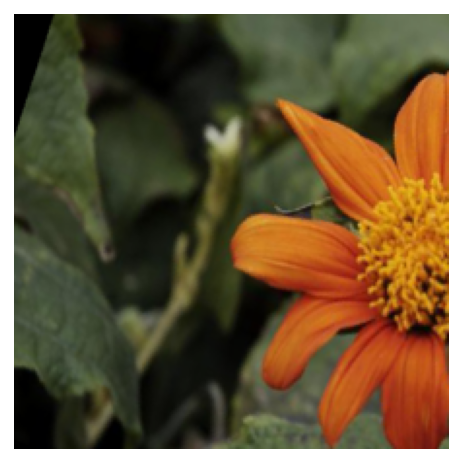

In [ ]:

image, label = next(iter(trainloader))
imshow(image[0,:]);

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda") #if the GPU is availble this method will return cuda.
    else:
        return torch.device("cpu")

def to_device(data, device): #in here we move the data to device of our choice, the GPU
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

    def __len__(self):
        return len(self.dl)

device = get_device()
device

device(type='cuda')

In [ ]:
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out =self(images)
        loss = F.mse_loss(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.mse_loss(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}

    def validation_epoch_end(self, outputs):
        batch_loss = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}

    def epoch_end(self, epoch, epochs, result):
        print("Epoch: [{}/{}], last_lr: {:.4f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch+1, epochs, result["lrs"][-1], result["train_loss"], result["val_loss"], result["val_acc"]))

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet34(pretrained=True)
        number_of_features = self.network.fc.in_features
        self.network.fc = nn.Linear(number_of_features, 104)

    def forward(self, xb):
        return self.network(xb)

    def freeze(self): #by freezing all the layers but the last one we allow it to warm up (the others are already good at training)
        for param in self.network.parameters():
            param.require_grad=False
        for param in self.network.fc.parameters():
            param.require_grad=True

    def unfreeze(self):
        for param in self.network.parameters():
            param.require_grad=True

In [ ]:

model = ResNet()

In [ ]:
model

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
 model = to_device(model, device)

In [ ]:
train_dl = DeviceDataLoader(trainloader, device)
val_dl = DeviceDataLoader(validloader, device)

In [ ]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=0,
                 grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()

    history = []
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()

            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            opt.step()
            opt.zero_grad()

            lrs.append(get_lr(opt))
            sched.step()

        result = evaluate(model, val_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, epochs, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, val_dl)]
history

<ipython-input-30-a6bed4e541f8>:15: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 104])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(out, labels)


RuntimeError: ignored

## **Freze**

In [ ]:
model.freeze()

In [ ]:
epochs = 10
max_lr = 10e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                       weight_decay=weight_decay, grad_clip=grad_clip,
                       opt_func=opt_func)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [1/10], last_lr: 0.0003, train_loss: 2.8666, val_loss: 0.8202, val_acc: 0.8356


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [2/10], last_lr: 0.0008, train_loss: 0.9709, val_loss: 1.4626, val_acc: 0.6529


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [3/10], last_lr: 0.0010, train_loss: 1.1282, val_loss: 2.3598, val_acc: 0.4987


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [4/10], last_lr: 0.0010, train_loss: 0.8736, val_loss: 0.5569, val_acc: 0.8407


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [5/10], last_lr: 0.0008, train_loss: 0.6423, val_loss: 0.3560, val_acc: 0.9029


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [6/10], last_lr: 0.0006, train_loss: 0.4890, val_loss: 0.2742, val_acc: 0.9320


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [7/10], last_lr: 0.0004, train_loss: 0.3367, val_loss: 0.1718, val_acc: 0.9501


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [8/10], last_lr: 0.0002, train_loss: 0.2356, val_loss: 0.1210, val_acc: 0.9748


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [9/10], last_lr: 0.0000, train_loss: 0.1807, val_loss: 0.1034, val_acc: 0.9760


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [10/10], last_lr: 0.0000, train_loss: 0.1505, val_loss: 0.1052, val_acc: 0.9784


Text(0, 0.5, 'Loss')

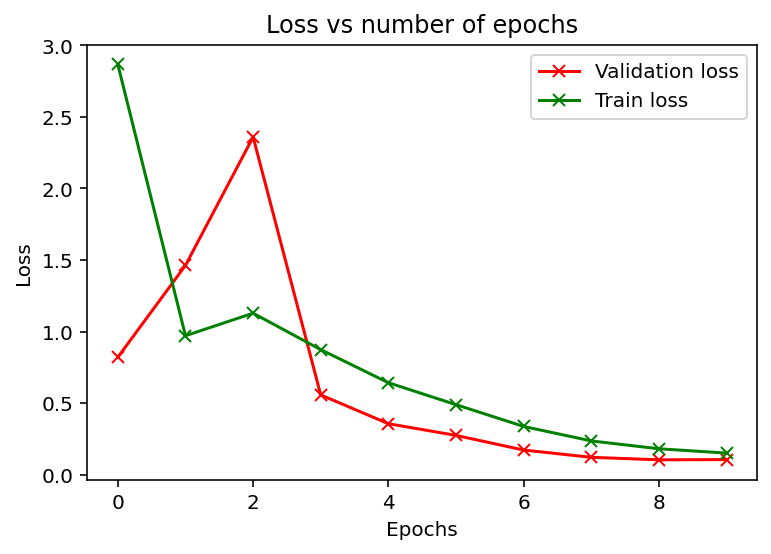

In [ ]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-rx")
plt.plot(train_loss, "-gx")
plt.title("Loss vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

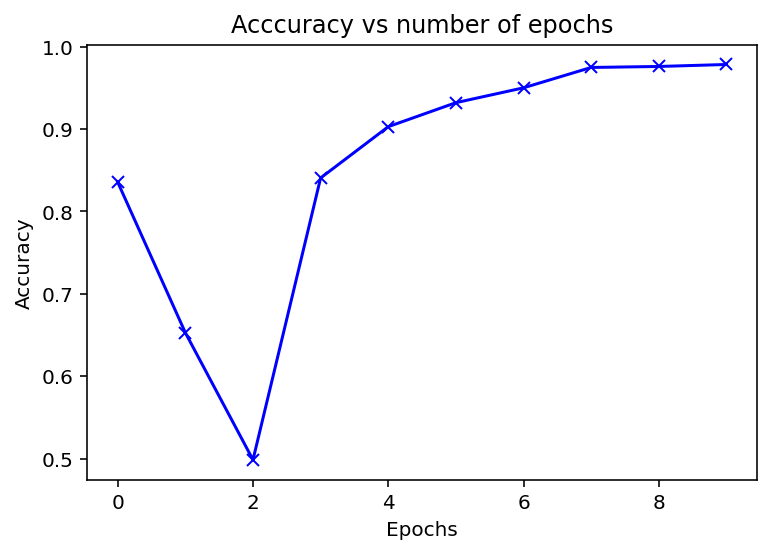

In [ ]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-bx")
plt.title("Acccuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

## Epochs 15

In [ ]:
model.freeze()
epochs = 15
max_lr = 10e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                       weight_decay=weight_decay, grad_clip=grad_clip,
                       opt_func=opt_func)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [1/15], last_lr: 0.0002, train_loss: 3.0875, val_loss: 1.0574, val_acc: 0.8061


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [2/15], last_lr: 0.0004, train_loss: 0.8796, val_loss: 0.8158, val_acc: 0.7846


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [3/15], last_lr: 0.0008, train_loss: 0.8810, val_loss: 1.0253, val_acc: 0.7212


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [4/15], last_lr: 0.0010, train_loss: 0.9556, val_loss: 1.0652, val_acc: 0.6971


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [5/15], last_lr: 0.0010, train_loss: 0.8504, val_loss: 0.7586, val_acc: 0.8052


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [6/15], last_lr: 0.0010, train_loss: 0.7145, val_loss: 0.4694, val_acc: 0.8743


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [7/15], last_lr: 0.0009, train_loss: 0.5583, val_loss: 0.3321, val_acc: 0.9133


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [8/15], last_lr: 0.0008, train_loss: 0.4530, val_loss: 0.3511, val_acc: 0.9092


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [9/15], last_lr: 0.0006, train_loss: 0.3674, val_loss: 0.1980, val_acc: 0.9450


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [10/15], last_lr: 0.0005, train_loss: 0.2754, val_loss: 0.1717, val_acc: 0.9534


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [11/15], last_lr: 0.0003, train_loss: 0.2248, val_loss: 0.1189, val_acc: 0.9688


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [12/15], last_lr: 0.0002, train_loss: 0.1582, val_loss: 0.1210, val_acc: 0.9724


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [13/15], last_lr: 0.0001, train_loss: 0.1537, val_loss: 0.0972, val_acc: 0.9748


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [14/15], last_lr: 0.0000, train_loss: 0.1435, val_loss: 0.0941, val_acc: 0.9784


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [15/15], last_lr: 0.0000, train_loss: 0.1260, val_loss: 0.0965, val_acc: 0.9748


Text(0, 0.5, 'Loss')

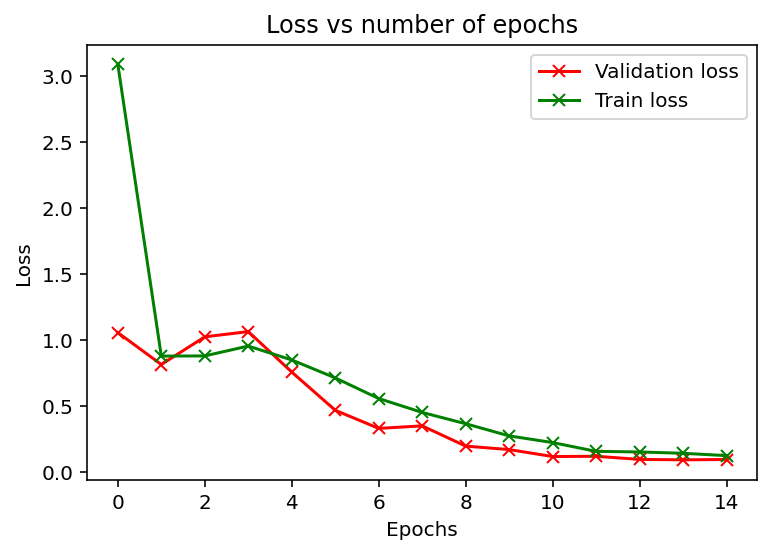

In [ ]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-rx")
plt.plot(train_loss, "-gx")
plt.title("Loss vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

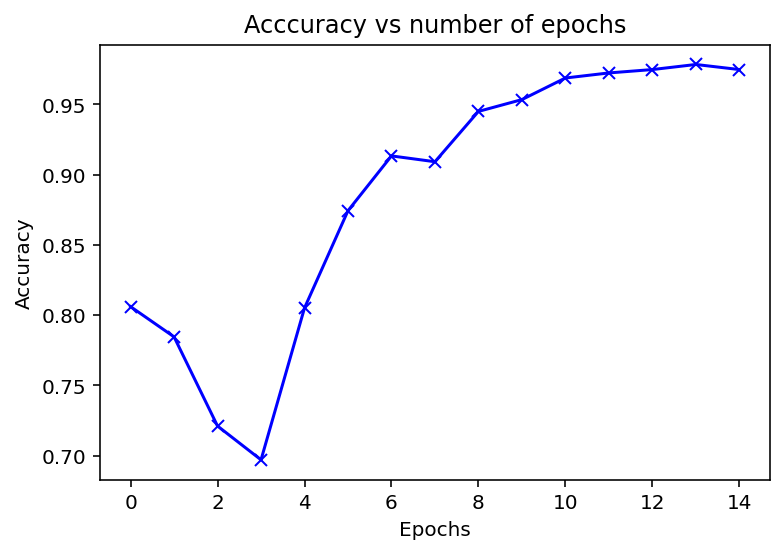

In [ ]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-bx")
plt.title("Acccuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

## Epochs 20

In [ ]:
model.freeze()

In [ ]:
epochs = 20
max_lr = 10e-4
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                       weight_decay=weight_decay, grad_clip=grad_clip,
                       opt_func=opt_func)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [1/20], last_lr: 0.0001, train_loss: 3.1927, val_loss: 1.3093, val_acc: 0.7734


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [2/20], last_lr: 0.0003, train_loss: 0.9972, val_loss: 0.3615, val_acc: 0.9366


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [3/20], last_lr: 0.0005, train_loss: 0.6804, val_loss: 1.0598, val_acc: 0.7342


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [4/20], last_lr: 0.0008, train_loss: 0.8396, val_loss: 1.1726, val_acc: 0.7007


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [5/20], last_lr: 0.0009, train_loss: 0.8522, val_loss: 1.3458, val_acc: 0.6612


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [6/20], last_lr: 0.0010, train_loss: 0.8229, val_loss: 0.5711, val_acc: 0.8383


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [7/20], last_lr: 0.0010, train_loss: 0.6771, val_loss: 0.7943, val_acc: 0.8229


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [8/20], last_lr: 0.0010, train_loss: 0.5745, val_loss: 0.3441, val_acc: 0.9140


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [9/20], last_lr: 0.0009, train_loss: 0.5115, val_loss: 0.5794, val_acc: 0.8657


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [10/20], last_lr: 0.0008, train_loss: 0.4131, val_loss: 0.2221, val_acc: 0.9414


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [11/20], last_lr: 0.0007, train_loss: 0.3788, val_loss: 0.2036, val_acc: 0.9507


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [12/20], last_lr: 0.0006, train_loss: 0.3018, val_loss: 0.2150, val_acc: 0.9510


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [13/20], last_lr: 0.0005, train_loss: 0.2506, val_loss: 0.2242, val_acc: 0.9414


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [14/20], last_lr: 0.0004, train_loss: 0.2154, val_loss: 0.1601, val_acc: 0.9627


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [15/20], last_lr: 0.0003, train_loss: 0.1708, val_loss: 0.1242, val_acc: 0.9712


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [16/20], last_lr: 0.0002, train_loss: 0.1504, val_loss: 0.1070, val_acc: 0.9772


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [17/20], last_lr: 0.0001, train_loss: 0.1209, val_loss: 0.1040, val_acc: 0.9784


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [18/20], last_lr: 0.0000, train_loss: 0.1157, val_loss: 0.1009, val_acc: 0.9772


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [19/20], last_lr: 0.0000, train_loss: 0.1147, val_loss: 0.1009, val_acc: 0.9772


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [20/20], last_lr: 0.0000, train_loss: 0.0884, val_loss: 0.1008, val_acc: 0.9796


Text(0, 0.5, 'Loss')

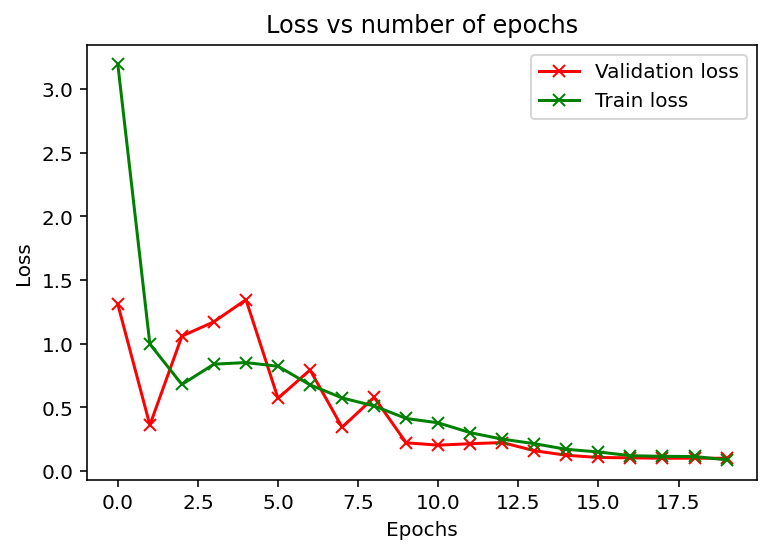

In [ ]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-rx")
plt.plot(train_loss, "-gx")
plt.title("Loss vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

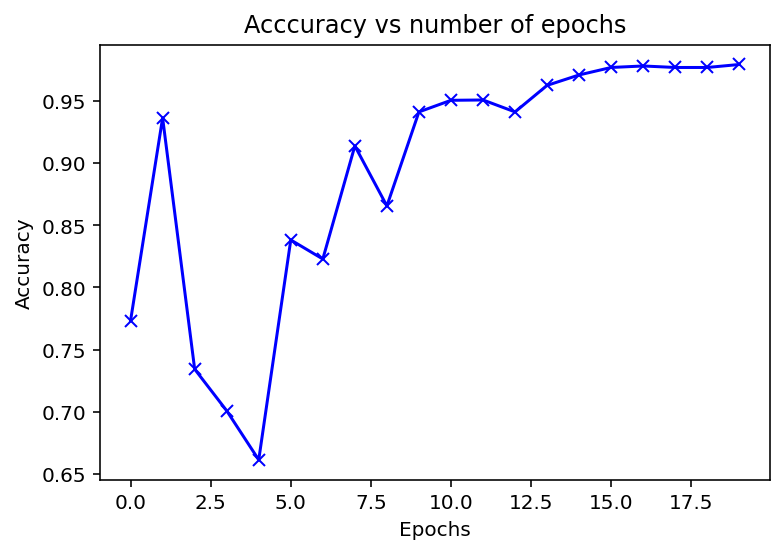

In [ ]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-bx")
plt.title("Acccuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

## **Fine Tuning**

In [ ]:
model.unfreeze()

In [ ]:
epochs = 10
max_lr = 0.0005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
%%time

history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                       weight_decay=weight_decay, grad_clip=grad_clip,
                       opt_func=opt_func)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [1/10], last_lr: 0.0001, train_loss: 3.4759, val_loss: 1.3526, val_acc: 0.7392


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [2/10], last_lr: 0.0004, train_loss: 1.0095, val_loss: 0.5968, val_acc: 0.8739


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [3/10], last_lr: 0.0005, train_loss: 0.7605, val_loss: 0.6518, val_acc: 0.8479


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [4/10], last_lr: 0.0005, train_loss: 0.6493, val_loss: 0.3738, val_acc: 0.9052


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [5/10], last_lr: 0.0004, train_loss: 0.4658, val_loss: 0.3291, val_acc: 0.9111


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [6/10], last_lr: 0.0003, train_loss: 0.3449, val_loss: 0.1934, val_acc: 0.9483


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [7/10], last_lr: 0.0002, train_loss: 0.2434, val_loss: 0.1187, val_acc: 0.9606


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [8/10], last_lr: 0.0001, train_loss: 0.1780, val_loss: 0.0917, val_acc: 0.9784


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [9/10], last_lr: 0.0000, train_loss: 0.1395, val_loss: 0.0893, val_acc: 0.9808


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [10/10], last_lr: 0.0000, train_loss: 0.1193, val_loss: 0.0839, val_acc: 0.9820
CPU times: user 12min 40s, sys: 2min 33s, total: 15min 13s
Wall time: 15min 14s


Text(0, 0.5, 'Loss')

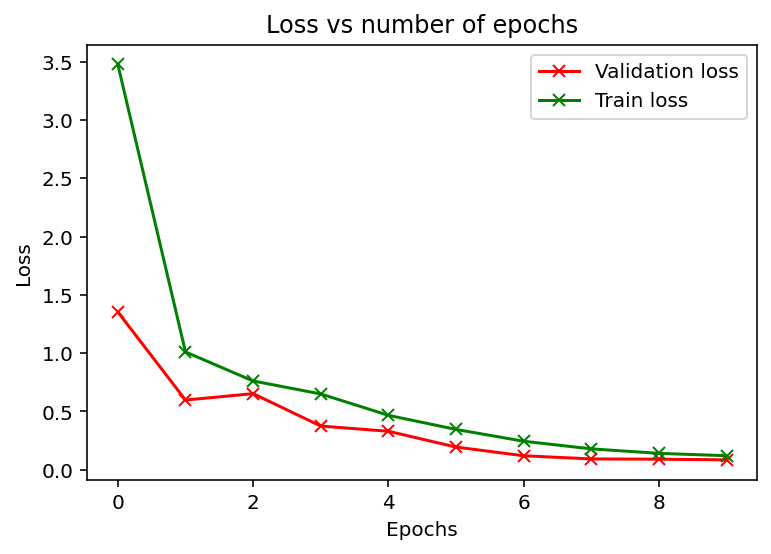

In [ ]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-rx")
plt.plot(train_loss, "-gx")
plt.title("Loss vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

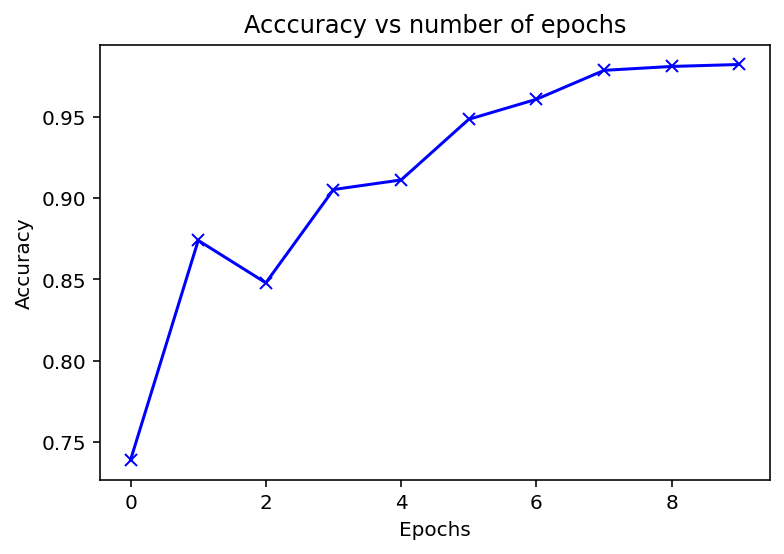

In [ ]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-bx")
plt.title("Acccuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

## Epochs 15

In [ ]:
epochs = 15
max_lr = 0.0005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                       weight_decay=weight_decay, grad_clip=grad_clip,
                       opt_func=opt_func)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [1/15], last_lr: 0.0001, train_loss: 3.7327, val_loss: 1.8445, val_acc: 0.6335


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [2/15], last_lr: 0.0002, train_loss: 1.2915, val_loss: 0.5176, val_acc: 0.9101


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [3/15], last_lr: 0.0004, train_loss: 0.6173, val_loss: 0.5601, val_acc: 0.8596


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [4/15], last_lr: 0.0005, train_loss: 0.6470, val_loss: 0.6935, val_acc: 0.8202


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [5/15], last_lr: 0.0005, train_loss: 0.6329, val_loss: 0.5136, val_acc: 0.8683


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [6/15], last_lr: 0.0005, train_loss: 0.4869, val_loss: 0.3721, val_acc: 0.8974


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [7/15], last_lr: 0.0004, train_loss: 0.4321, val_loss: 0.3430, val_acc: 0.8972


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [8/15], last_lr: 0.0004, train_loss: 0.3635, val_loss: 0.1534, val_acc: 0.9639


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [9/15], last_lr: 0.0003, train_loss: 0.2832, val_loss: 0.1905, val_acc: 0.9543


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [10/15], last_lr: 0.0002, train_loss: 0.2121, val_loss: 0.1470, val_acc: 0.9663


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [11/15], last_lr: 0.0002, train_loss: 0.1518, val_loss: 0.1060, val_acc: 0.9796


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [12/15], last_lr: 0.0001, train_loss: 0.1349, val_loss: 0.1114, val_acc: 0.9750


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [13/15], last_lr: 0.0000, train_loss: 0.1087, val_loss: 0.0940, val_acc: 0.9796


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [14/15], last_lr: 0.0000, train_loss: 0.1020, val_loss: 0.0952, val_acc: 0.9796


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [15/15], last_lr: 0.0000, train_loss: 0.0919, val_loss: 0.0963, val_acc: 0.9786


Text(0, 0.5, 'Loss')

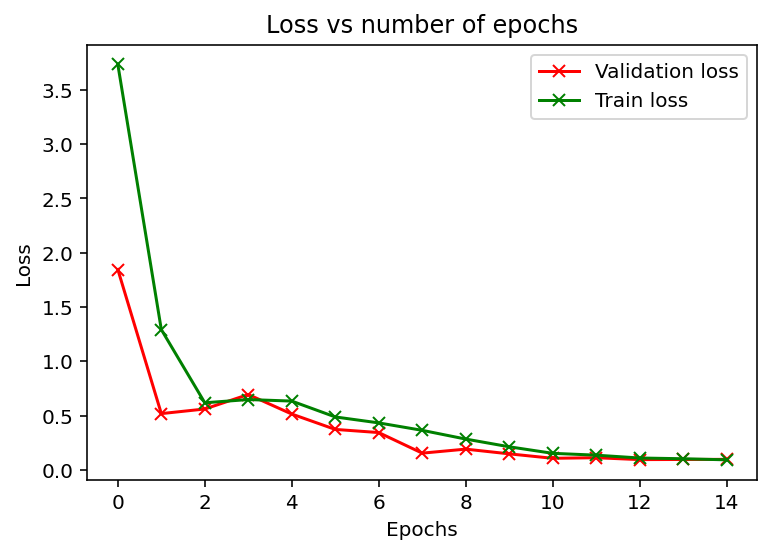

In [ ]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-rx")
plt.plot(train_loss, "-gx")
plt.title("Loss vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

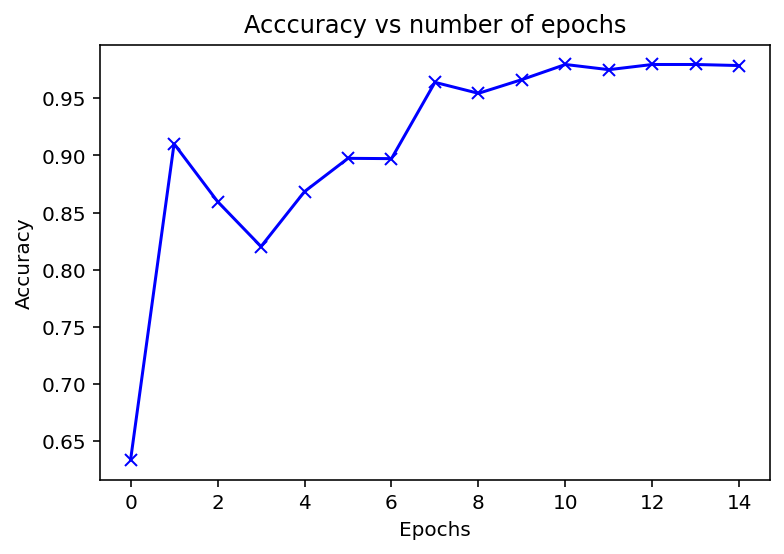

In [ ]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-bx")
plt.title("Acccuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

## Epochs 20

In [ ]:
epochs = 20
max_lr = 0.0005
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [ ]:
history = fit_one_cycle(epochs, max_lr, model, train_dl, val_dl,
                       weight_decay=weight_decay, grad_clip=grad_clip,
                       opt_func=opt_func)

  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [1/20], last_lr: 0.0001, train_loss: 3.2497, val_loss: 1.8486, val_acc: 0.6659


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [2/20], last_lr: 0.0001, train_loss: 1.4244, val_loss: 0.4941, val_acc: 0.9308


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [3/20], last_lr: 0.0003, train_loss: 0.6036, val_loss: 0.4074, val_acc: 0.9188


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [4/20], last_lr: 0.0004, train_loss: 0.5704, val_loss: 0.4713, val_acc: 0.8825


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [5/20], last_lr: 0.0005, train_loss: 0.6259, val_loss: 0.6225, val_acc: 0.8343


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [6/20], last_lr: 0.0005, train_loss: 0.5554, val_loss: 0.5039, val_acc: 0.8670


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [7/20], last_lr: 0.0005, train_loss: 0.4865, val_loss: 0.2929, val_acc: 0.9366


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [8/20], last_lr: 0.0005, train_loss: 0.4194, val_loss: 0.4001, val_acc: 0.8993


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [9/20], last_lr: 0.0004, train_loss: 0.3742, val_loss: 0.2393, val_acc: 0.9363


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [10/20], last_lr: 0.0004, train_loss: 0.3121, val_loss: 0.3643, val_acc: 0.9128


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [11/20], last_lr: 0.0004, train_loss: 0.2526, val_loss: 0.1711, val_acc: 0.9534


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [12/20], last_lr: 0.0003, train_loss: 0.2218, val_loss: 0.1693, val_acc: 0.9603


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [13/20], last_lr: 0.0003, train_loss: 0.1926, val_loss: 0.1214, val_acc: 0.9663


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [14/20], last_lr: 0.0002, train_loss: 0.1663, val_loss: 0.1079, val_acc: 0.9784


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [15/20], last_lr: 0.0001, train_loss: 0.1461, val_loss: 0.1129, val_acc: 0.9712


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [16/20], last_lr: 0.0001, train_loss: 0.1194, val_loss: 0.0872, val_acc: 0.9784


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [17/20], last_lr: 0.0001, train_loss: 0.0939, val_loss: 0.0903, val_acc: 0.9796


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [18/20], last_lr: 0.0000, train_loss: 0.0867, val_loss: 0.0826, val_acc: 0.9784


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [19/20], last_lr: 0.0000, train_loss: 0.0817, val_loss: 0.0832, val_acc: 0.9784


  0%|          | 0/103 [00:00<?, ?it/s]

Epoch: [20/20], last_lr: 0.0000, train_loss: 0.0807, val_loss: 0.0821, val_acc: 0.9796


Text(0, 0.5, 'Loss')

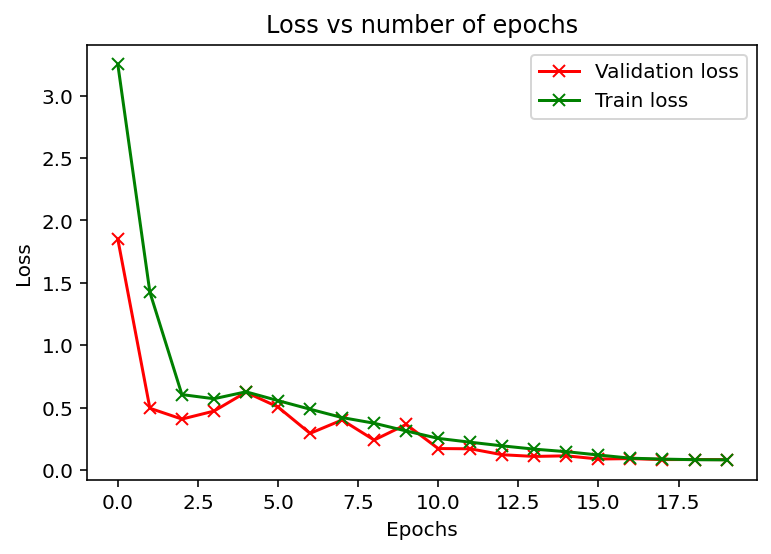

In [ ]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-rx")
plt.plot(train_loss, "-gx")
plt.title("Loss vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

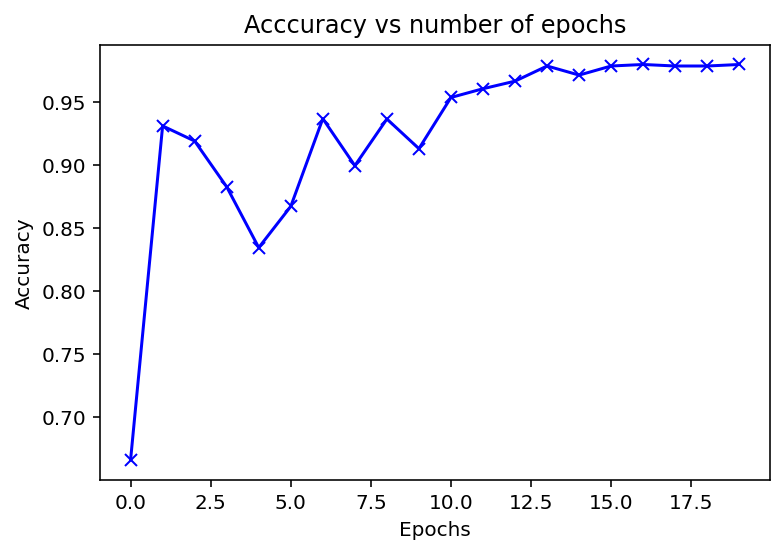

In [ ]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-bx")
plt.title("Acccuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")